# Ex10 뉴스기사 요약해보기

## Step1 데이터 수집하기

### 뉴스기사를 다운받습니다.

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 이 데이터는 헤드라인과 텍스트 내용이 있습니다.

In [2]:
data.sample(10)

,headlines,text
92821,Pleasure to open innings with you: Gayle to Kohli,Following their 122-run stand for the first wi...
16925,Nigeria declares national disaster after flood...,At least 100 people have died in floods across...
15077,Saudi puts world's biggest solar power project...,Saudi Arabia has put on hold a $200 billion pl...
70752,Russia investigation waste of time: Ex-Trump a...,The investigation into possible collusion betw...
49703,Facebook posts $13 billion in revenue in 2017 Q4,Facebook has posted a revenue of $12.97 billio...
78672,Swiggy CEO responds to blog post claiming it f...,Swiggy CEO Sriharsha Majety has responded to a...
65579,Women must use 'Doklam diplomacy' to convince ...,Replying to a question during an interaction w...
36757,Hope I get to work with Kareena in future: Kar...,"Kartik Aaryan, who recently walked the ramp wi..."
3774,I'll be your sister for life: Dipika to Sreesa...,"After winning Bigg Boss 12, television actress..."
46408,Apple devices at US centre making fake calls t...,Apple devices at a repair centre in California...


## Step2 데이터 전처리하기(추상적 요약)

### 텍스트열 데이터에 대한 중복값을 제외했습니다.

In [3]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [4]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 결측치가 있나 확인해봤습니다.

In [5]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 축약어에대한 사전을 만들었습니다.

In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 불용어를 확인했습니다.

In [7]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

### 불용어 및 특수문자를 제거했습니다.

In [8]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

### 예제를 적용시켜 확인해봤습니다.

In [9]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


### 전체 데이터에 적용시켰습니다.

In [10]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_headlines)


421.05774545669556  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

### 빈 값이 있으면 null값으로 대체했습니다.

In [11]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [12]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [13]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 텍스트와 헤드라인에 대한 데이터 시각화를 했습니다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


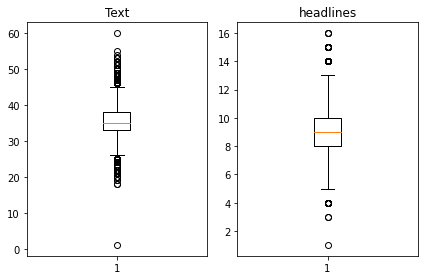

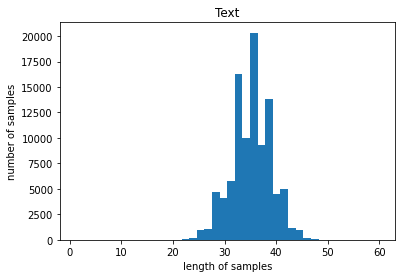

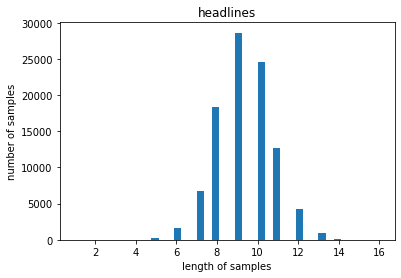

In [14]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headline_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headline_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headline_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 샘플을 대부분 활용할 수 있도록 텍스트와 헤드라인의 최대길이를 정했습니다.

In [15]:
text_max_len = 50
headlines_max_len = 13
print('=3')

=3


In [16]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [18]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98166


### 시작토큰과 종료토큰 추가했습니다.

In [19]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [20]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [21]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 1470 70412 61078 ... 39266 17777 57844]


In [22]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


### 훈련데이터와 테스트데이터를 8:2로 나눴습니다.

In [23]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19633


In [24]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78533
훈련 레이블의 개수 : 78533
테스트 데이터의 개수 : 19633
테스트 레이블의 개수 : 19633


In [25]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


### 단어집합을만들고 정수값을 부여했습니다.

In [26]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69580
등장 빈도가 6번 이하인 희귀 단어의 수: 47443
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22137
단어 집합에서 희귀 단어의 비율: 68.18482322506468
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4965689536197413


In [27]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1780, 635, 2941, 756, 1799, 1455, 644, 1104, 4247, 3, 1269, 514, 185, 2, 7, 3175, 4646, 1158, 177, 2836, 2895, 298, 1269, 208, 1847, 67, 172, 6375, 2531, 1848], [692, 6064, 7864, 3919, 208, 496, 286, 99, 7, 184, 7, 961, 2439, 654, 3065, 1141, 286, 24, 1, 210, 30, 5814, 173, 961, 303], [66, 53, 728, 4177, 90, 1673, 1044, 922, 2369, 64, 977, 223, 62, 2776, 66, 1044, 1573, 146, 37, 5866, 1256, 1, 950, 352, 51, 1044, 41, 175, 402, 37, 23, 786]]


In [28]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [29]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30055
등장 빈도가 5번 이하인 희귀 단어의 수: 19670
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10385
단어 집합에서 희귀 단어의 비율: 65.44668108467809
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.6603964021017426


### 등장 빈도가 6회 미만인 단어들의 집합의 크기에 따라 단어집합의 크기를 제한했습니다.

In [30]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 748, 777, 3, 249, 9, 45, 4, 430], [1, 4, 1009, 6, 4, 61], [1, 1131, 1348, 1543, 284, 78, 330], [1, 50, 92, 58, 258, 167, 3, 835, 176], [1, 1269, 6, 686, 387, 94, 57, 403, 7, 231]]
target
decoder  [[748, 777, 3, 249, 9, 45, 4, 430, 2], [4, 1009, 6, 4, 61, 2], [1131, 1348, 1543, 284, 78, 330, 2], [50, 92, 58, 258, 167, 3, 835, 176, 2], [1269, 6, 686, 387, 94, 57, 403, 7, 231, 2]]


### 빈 것에대해 삭제했습니다.

In [31]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 12
삭제할 테스트 데이터의 개수 : 2


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


훈련 데이터의 개수 : 78521
훈련 레이블의 개수 : 78521
테스트 데이터의 개수 : 19631
테스트 레이블의 개수 : 19631


### LSTM기반으로 모델을 설계했으며 드랍아웃을 적용했습니다.

In [32]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


### 디코더를 설계했습니다.

In [34]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [35]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## Step 3 어텐션 메커니즘 사용하기(추상적 요약)

### 어텐션 함수를 다운받고 적용했습니다.

In [36]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [37]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 훈련을 시작했습니다.

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 262s 811ms/step - loss: 3.9187 - val_loss: 3.2839
Epoch 2/50
307/307 [==============================] - 247s 806ms/step - loss: 3.2142 - val_loss: 2.9841
Epoch 3/50
307/307 [==============================] - 247s 805ms/step - loss: 2.9561 - val_loss: 2.7958
Epoch 4/50
307/307 [==============================] - 247s 806ms/step - loss: 2.7571 - val_loss: 2.6545
Epoch 5/50
307/307 [==============================] - 248s 806ms/step - loss: 2.6060 - val_loss: 2.5536
Epoch 6/50
307/307 [==============================] - 247s 805ms/step - loss: 2.4924 - val_loss: 2.4822
Epoch 7/50
307/307 [==============================] - 247s 805ms/step - loss: 2.4045 - val_loss: 2.4243
Epoch 8/50
307/307 [==============================] - 247s 806ms/step - loss: 2.3210 - val_loss: 2.3853
Epoch 9/50
307/307 [==============================] - 246s 800ms/step - loss: 2.2715 - val_loss: 2.3477
Epoch 10/50
307/307 [==============================] - 245s 798m

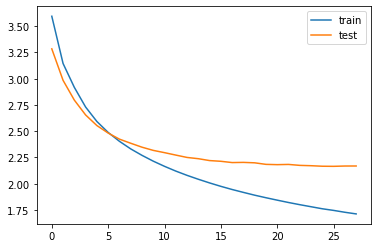

In [39]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [40]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 인퍼런스 모델 구현했습니다.

In [41]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [42]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [43]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트하기

In [44]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headline(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

### 50개의 샘플을통해 실제요약과 예측요약을 살펴봤습니다.

In [45]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2headline(decoder_input_test[i]))
    print("예측 헤드라인 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : pm narendra modi sunday inaugurated dedicated nation newly national police memorial newly built police museum delhi foot tall tonne heavy black sculpture wall bearing names martyred personnel also unveiled event 
실제 헤드라인 : pm modi police museum in delhi 
예측 헤드라인 :  pm modi to be built in red


원문 : actress neha dhupia recently got married actor angad bedi thanked karan johar congratulating tweeting thank added karan hearts joy huge reason happiness neha angad tied knot traditional sikh wedding ceremony thursday 
실제 헤드라인 : you to johar on her marriage to 
예측 헤드라인 :  karan johar on johar


원문 : th birthday monday madhya pradesh cm shivraj singh chouhan announced state government give birth child poor family adding government wants poor live comfortable life birth till death chouhan said also provided last rites poor person 
실제 헤드라인 : madhya pradesh announces on for poor 
예측 헤드라인 :  day of birth of poor govt mp cm


원문 : european organisation nuclear research world largest particle p

예측 헤드라인 :  amazon loses billion in market value


원문 : school japan adopted school uniforms designed italian fashion brand students school said aims create atmosphere suitable school uniform costs students parents criticised move saying sends wrong message expensive things good 
실제 헤드라인 : japan school worth for kids 
예측 헤드라인 :  school school students with in school


원문 : maharashtra cabinet thursday announced crore relief farmers government also decided grant ex gratia per upper limit per farmer kitchen sold november december comes amid reports farmers selling per kg 
실제 헤드라인 : maha cabinet approves crore relief for farmers 
예측 헤드라인 :  maharashtra govt approves crore loan for farmers


원문 : brian vice president maps uber quit ride hailing startup almost two years joining joined uber years working google moving explore politics exit follows number top level uber including president self driving technology unit head 
실제 헤드라인 : uber vice president of quits 
예측 헤드라인 :  uber ceo quits afte

### Step5 Summa을 이용해서 추출적 요약 적용하기

In [48]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [51]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [52]:
from summa.summarizer import summarize

In [58]:
for i in range(50, 100):
    print("Summary", i+1)
    print("원문 : ", data['text'][i])
    print("요약 : ", data['headlines'][i])
    print("추출적 요약 : ", summarize(data['text'][i], words=16))
    print("\n")

Summary 51
원문 :  Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
요약 :  Yashwant Sinha demands probe into alleged fund diversion by DHFL
추출적 요약 :  Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


Summary 52
원문 :  US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker 

# 회고

1. 처음으로 돌렸을 때 결과가 좋지않아 무엇때문인가 생각해봤더니 텍스트의 최대길이와 headline의 최대 길이를 많은 부분을 커버하도록 설정하지않아서 였던 것 같습니다.99프로 커버하도록 수치를 바꿔줬습니다.
2. 추상적 요약과 추출적요약 두가지 모델을 적용시켜봤습니다. 
3. 모델을 적용시켜본 결과 추상적요약은 실제 헤드라인과 예측 헤드라인이 핵심 단어는 어느정도 같은것이 있긴했으나 문법적으로 말이안되는 것들이 많았습니다. 
4. 추출적 요약은 핵심 단어포함도잘되고 문법적으로도 추상적요약보다 더 완성도가 높게 나왔습니다. 추출적요약이 추상적 요약보다 훨씬 좋은 결과를 얻었습니다.
5. 추출적 요약을 적용할 때 빈 부분이 많아 여러 파라미터를 적용시켜봤으나 여전히 빈 부분이 좀 있어 개선이 필요해보입니다.